# **Práctica de Gestión de Riesgos**

### **Marco Corpa Criado**
### **Daniel García López**

## **Fase 0: Preparación de los datos**

### 1. Contexto y Objetivos
En esta sección inicializamos el entorno de trabajo y construimos la base de datos necesaria para alimentar el modelo de **Regímenes de Mercado (HMM)** y el **Motor de Stress Testing**. Realizamos un proceso de *Feature Engineering* para transformar los precios brutos en indicadores estacionarios capaces de distinguir entre ruido, euforia y pánico real.

### 2. Selección de Datos y Variables
Para entrenar el modelo HMM (Fase 1) y detectar con precisión los estados de calma o crisis, hemos seleccionado un vector de observación refinado para evitar falsos positivos:

#### A. Renta Variable (Direccionalidad)
* **Indicador:** Retornos Logarítmicos del **S&P 500** (`^GSPC`).
* **Justificación:** Captura la dirección general del mercado y el sentimiento diario de los inversores.
* **Transformación:** $R_t = \ln(P_t / P_{t-1})$.

#### B. Volatilidad Bajista 
* **Indicador:** Semidesviación rodada a 21 días ($\sigma^{down}$).
* **Construcción:** Se calcula la desviación estándar **exclusivamente sobre los retornos negativos** ($R_t < 0$). Si el mercado sube, este indicador se mantiene en 0.
* **Justificación Económica:** La volatilidad estándar es simétrica; se dispara tanto en pánicos como en *rallies* alcistas agresivos (ej. Boom de IA en 2024).
    * **La Solución:** Al filtrar solo la volatilidad a la baja, el modelo distingue correctamente entre euforia (Alta Volatilidad Total, Baja Downside Vol) y pánico (Alta Volatilidad Total, Alta Downside Vol).

#### C. Shock de Crédito 
* **Indicador:** Variación del Ratio de Estrés Crediticio ($\Delta \frac{\text{Treasuries}}{\text{High Yield}}$).
* **Construcción:** Primera diferencia diaria del cociente entre el precio del bono seguro (IEF) y el bono basura (HYG).
* **Justificación Económica:**
    * El nivel absoluto del ratio tiene una tendencia histórica debido a la bajada secular de tipos (2008-2021).
    * Usar la **variación diaria** ($\Delta$) elimina esa tendencia y permite detectar el momento exacto de la "rotura" de liquidez o *Flight to Quality*, independientemente del nivel de los tipos de interés.

#### D. Volatilidad Implícita
* **Indicador:** Nivel del **VIX** (`^VIX`).
* **Justificación:** Conocido como el "índice del miedo". Mide la expectativa de volatilidad futura en el mercado de opciones. Actúa como complemento prospectivo a la volatilidad realizada.

#### E. Tipos de Interés (Soberanos)
* **Indicador:** Rentabilidad del Bono del Tesoro a 10 años (**US10Y**) y su variación.
* **Justificación:** Es fundamental para capturar cambios de régimen inflacionarios (como en 2022), donde la correlación entre bonos y acciones se vuelve positiva, rompiendo la protección tradicional de la cartera.

#### F. Drawdown (Variable de Contexto)
* **Indicador:** Drawdown Acumulado desde el Máximo Histórico ($DD_t$).
* **Construcción:** $DD_t = \frac{P_t - \text{Max}(P_{0}...P_t)}{\text{Max}(P_{0}...P_t)}$. 
* **Uso:** Aunque se retiró como input directo del HMM para evitar que el modelo marcara crisis durante recuperaciones largas (ej. 2009-2013), se mantiene como variable de validación visual para medir la "profundidad del dolor" patrimonial.

### 3. Ventana Temporal y Calidad del Dato
* **Inicio:** 1 de enero de 2006.
* **Motivo:** Es **crítico** incluir la Gran Crisis Financiera de 2008 en el conjunto de entrenamiento. Si el modelo no "ve" 2008, no aprenderá correctamente las dinámicas de correlación extrema y colas pesadas necesarias para los Escenarios de Estrés.
* **Proxies:** Para la cartera, utilizamos ETFs líquidos (`IEF`, `SHY`, `HYG`) como proxies invertibles de los bonos gubernamentales y corporativos teóricos solicitados en el enunciado.

Iniciando proceso de descarga desde 2006-01-01 hasta 2026-02-09...
Descargando 3 activos...
✅ Datos de Mercado descargados correctamente.
Descargando 18 activos...
✅ Datos de Cartera descargados correctamente.

Generando gráfico de evolución histórica...


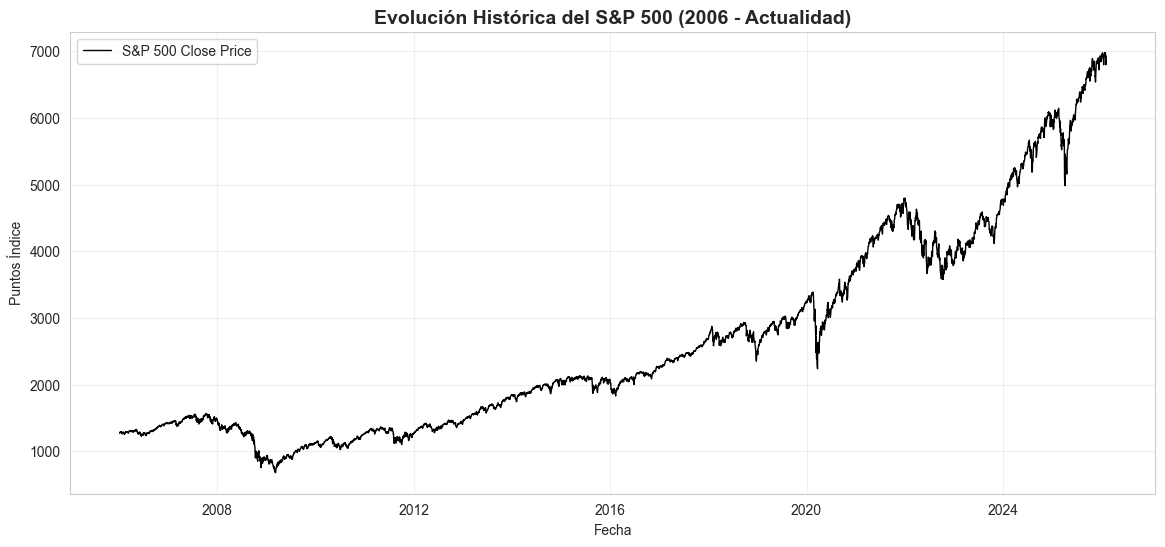


Generando todos los indicadores avanzados...
Datos listos. Muestras finales: 4737


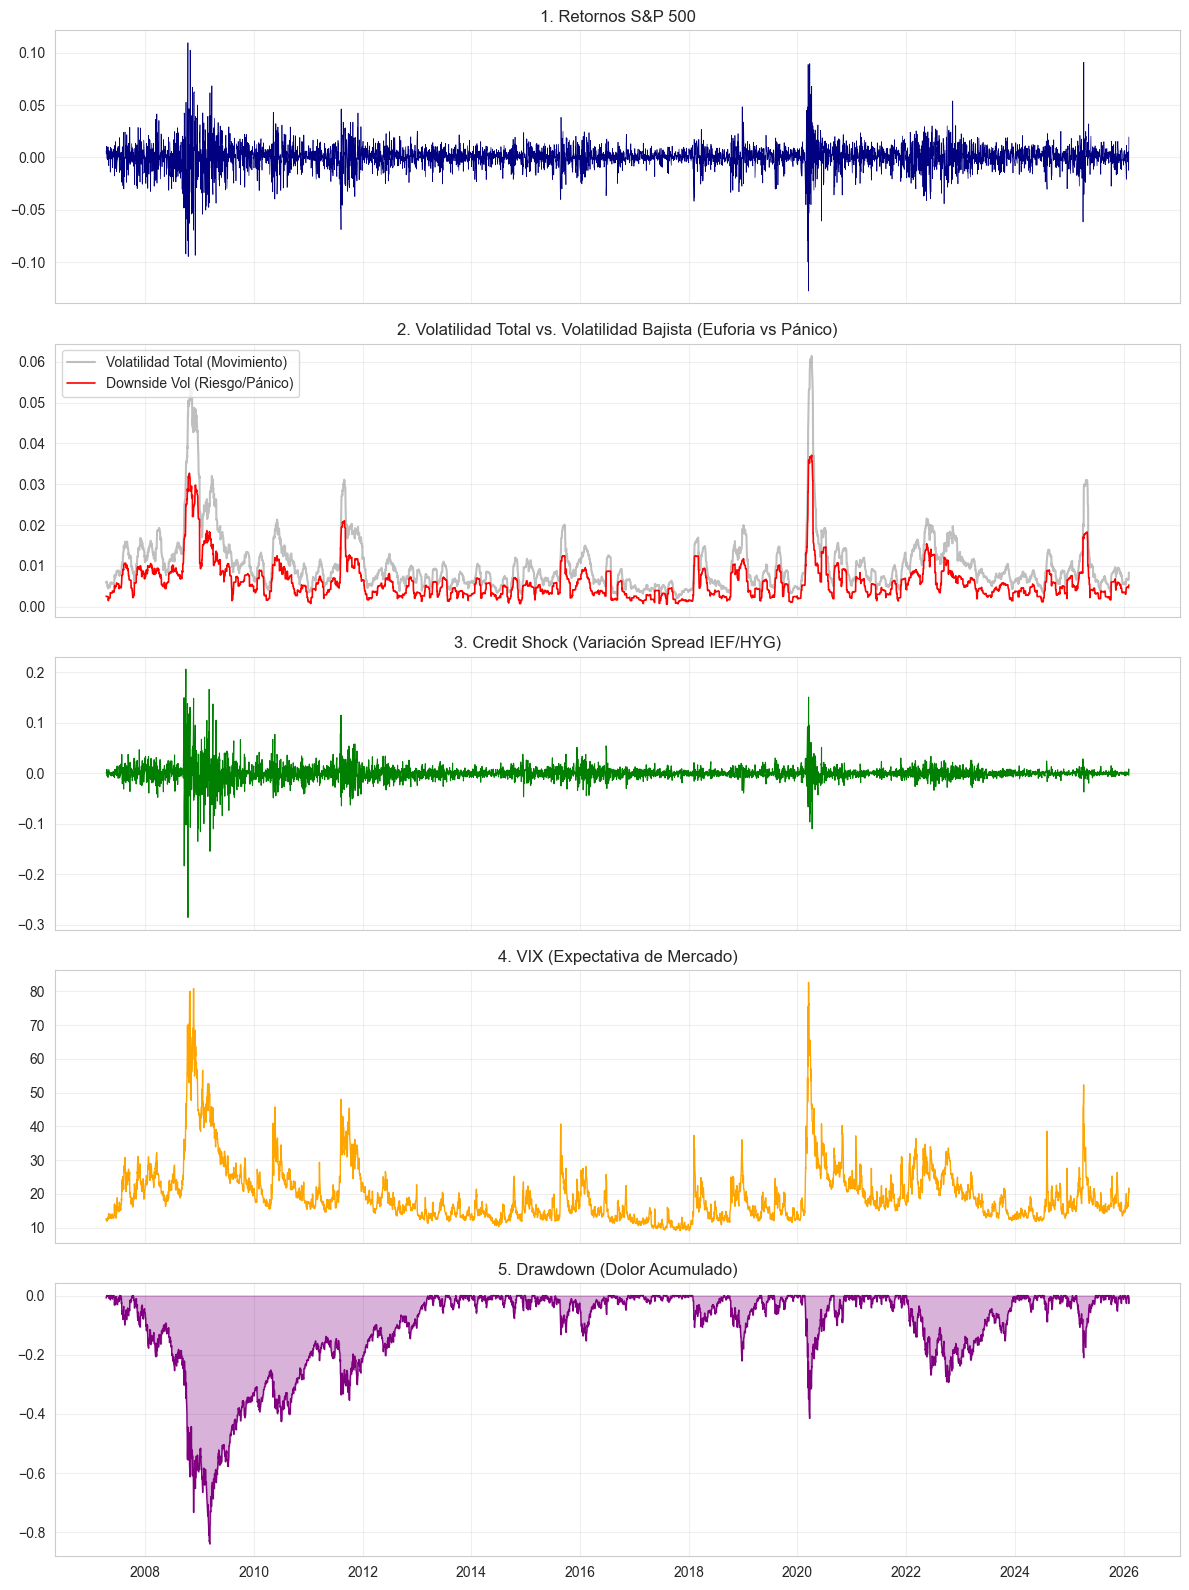


--- ESTADÍSTICAS DESCRIPTIVAS ---


,count,mean,std,min,25%,50%,75%,max
S&P500_Ret,4737.0,0.000332,0.012574,-0.127652,-0.004167,0.000720,0.005921,0.109572
Rolling_Vol,4737.0,0.010371,0.007249,0.002185,0.006142,0.008468,0.012330,0.061454
Downside_Vol,4737.0,0.006090,0.004672,0.000599,0.003197,0.005018,0.007569,0.037133
Drawdown,4737.0,-0.108186,0.145543,-0.838760,-0.159171,-0.043777,-0.007225,0.000000


In [22]:
# ==============================================================================
# FASE 0: PREPARACIÓN DEL ENTORNO Y DATOS (V. FINAL COMPLETA)
# ==============================================================================

# --- INSTALACIÓN DE LIBRERÍAS (Si no las tienes) ---
# !pip install yfinance hmmlearn scipy statsmodels seaborn matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Semilla
np.random.seed(42)

# --- DEFINICIÓN DE TICKERS ---

market_tickers = {
    'SP500': '^GSPC',  # Mercado
    'VIX': '^VIX',     # Volatilidad Implícita
    'US10Y_Yield': '^TNX' # Tipos
}

portfolio_tickers = [
    'AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 
    'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM', 
    'IEF', 'SHY', 'HYG' 
]

start_date = '2006-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

print(f"Iniciando proceso de descarga desde {start_date} hasta {end_date}...")

# --- FUNCIÓN DE DESCARGA ---
def download_and_process(tickers_list, start, end):
    print(f"Descargando {len(tickers_list)} activos...")
    raw_data = yf.download(tickers_list, start=start, end=end, progress=False, auto_adjust=False)
    
    if raw_data.empty:
        raise ValueError("Error: La descarga devolvió un DataFrame vacío.")

    # Ajuste para diferentes versiones de yfinance
    if 'Adj Close' in raw_data.columns:
        data = raw_data['Adj Close']
    elif 'Close' in raw_data.columns:
        data = raw_data['Close']
    else:
        data = raw_data

    data = data.ffill()
    data = data.dropna(how='all')
    
    log_returns = np.log(data / data.shift(1))
    log_returns = log_returns.dropna(how='all')
    
    return data, log_returns

# --- EJECUCIÓN DE DESCARGAS ---

# 1. Datos de Mercado
try:
    market_prices, market_returns = download_and_process(list(market_tickers.values()), start_date, end_date)
    mapper = {v: k for k, v in market_tickers.items()}
    market_prices.rename(columns=mapper, inplace=True)
    market_returns.rename(columns=mapper, inplace=True)
    
    if '^GSPC' in market_prices.columns: market_prices.rename(columns={'^GSPC': 'SP500'}, inplace=True)
    if '^VIX' in market_prices.columns: market_prices.rename(columns={'^VIX': 'VIX'}, inplace=True)
    if '^TNX' in market_prices.columns: market_prices.rename(columns={'^TNX': 'US10Y_Yield'}, inplace=True)

    print("✅ Datos de Mercado descargados correctamente.")
except Exception as e:
    print(f"❌ Error descargando Mercado: {e}")

# 2. Datos de Cartera
try:
    portfolio_prices, portfolio_returns = download_and_process(portfolio_tickers, start_date, end_date)
    print("✅ Datos de Cartera descargados correctamente.")
except Exception as e:
    print(f"❌ Error descargando Cartera: {e}")


# ==============================================================================
# VISUALIZACIÓN 1: EVOLUCIÓN HISTÓRICA DEL S&P 500 (¡LO QUE PEDISTE!)
# ==============================================================================
print("\nGenerando gráfico de evolución histórica...")
plt.figure(figsize=(14, 6))
plt.plot(market_prices.index, market_prices['SP500'], color='black', linewidth=1, label='S&P 500 Close Price')
plt.title('Evolución Histórica del S&P 500 (2006 - Actualidad)', fontsize=14, fontweight='bold')
plt.ylabel('Puntos Índice')
plt.xlabel('Fecha')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


# --- FEATURE ENGINEERING COMPLETO ---
print("\nGenerando todos los indicadores avanzados...")
df_hmm = pd.DataFrame(index=market_prices.index)

# A. Retorno
df_hmm['S&P500_Ret'] = np.log(market_prices['SP500'] / market_prices['SP500'].shift(1))

# B. Volatilidades (COMPARATIVA)
# 1. Volatilidad Normal (21 días): Mide "Movimiento" (sea arriba o abajo)
df_hmm['Rolling_Vol'] = df_hmm['S&P500_Ret'].rolling(window=21).std()

# 2. Volatilidad Bajista (Downside): Mide "Pánico" (solo caídas)
neg_ret = df_hmm['S&P500_Ret'].copy()
neg_ret[neg_ret > 0] = 0
df_hmm['Downside_Vol'] = neg_ret.rolling(window=21).std()

# 3. VIX (Implícita)
df_hmm['VIX_Level'] = market_prices['VIX']

# C. Tipos
df_hmm['US10Y_Yield'] = market_prices['US10Y_Yield']
df_hmm['US10Y_Chg'] = df_hmm['US10Y_Yield'].diff() 

# D. Crédito (Shock)
aligned_portfolio = portfolio_prices.reindex(df_hmm.index)
df_hmm['Credit_Stress'] = aligned_portfolio['IEF'] / aligned_portfolio['HYG']
df_hmm['Credit_Shock'] = df_hmm['Credit_Stress'].diff()

# E. Drawdown (Profundidad de la caída)
cumulative_ret = df_hmm['S&P500_Ret'].cumsum()
rolling_max = cumulative_ret.cummax()
df_hmm['Drawdown'] = cumulative_ret - rolling_max

# Limpieza final
df_hmm_clean = df_hmm.dropna()

print(f"Datos listos. Muestras finales: {len(df_hmm_clean)}")

# --- VISUALIZACIÓN 2: PANEL DE INDICADORES ---
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True)

# 1. Retornos
axes[0].plot(df_hmm_clean.index, df_hmm_clean['S&P500_Ret'], color='navy', lw=0.5)
axes[0].set_title('1. Retornos S&P 500')
axes[0].grid(True, alpha=0.3)

# 2. Comparativa de Volatilidades (¡MUY ÚTIL!)
axes[1].plot(df_hmm_clean.index, df_hmm_clean['Rolling_Vol'], color='grey', alpha=0.5, lw=1.5, label='Volatilidad Total (Movimiento)')
axes[1].plot(df_hmm_clean.index, df_hmm_clean['Downside_Vol'], color='red', lw=1.2, label='Downside Vol (Riesgo/Pánico)')
axes[1].set_title('2. Volatilidad Total vs. Volatilidad Bajista (Euforia vs Pánico)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. Credit Shock
axes[2].plot(df_hmm_clean.index, df_hmm_clean['Credit_Shock'], color='green', lw=0.8)
axes[2].set_title('3. Credit Shock (Variación Spread IEF/HYG)')
axes[2].grid(True, alpha=0.3)

# 4. VIX
axes[3].plot(df_hmm_clean.index, df_hmm_clean['VIX_Level'], color='orange', lw=1)
axes[3].set_title('4. VIX (Expectativa de Mercado)')
axes[3].grid(True, alpha=0.3)

# 5. Drawdown
axes[4].plot(df_hmm_clean.index, df_hmm_clean['Drawdown'], color='purple', lw=1)
axes[4].fill_between(df_hmm_clean.index, df_hmm_clean['Drawdown'], 0, color='purple', alpha=0.3)
axes[4].set_title('5. Drawdown (Dolor Acumulado)')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen estadístico
print("\n--- ESTADÍSTICAS DESCRIPTIVAS ---")
display(df_hmm_clean[['S&P500_Ret', 'Rolling_Vol', 'Downside_Vol', 'Drawdown']].describe().T)

## **Fase 1: Detección de Regímenes de Mercado (Modelo HMM)**

### 1. Contexto y Objetivos
En esta fase implementamos un algoritmo de aprendizaje no supervisado, específicamente un **Modelo Oculto de Markov Gaussiano (Gaussian HMM)**, para inferir la secuencia de estados latentes del mercado $S_t$. 

El objetivo principal es clasificar cada sesión de negociación en uno de dos regímenes excluyentes:
* **Estado 0 (Calma / Risk-On):** Caracterizado por baja volatilidad y correlaciones estándar.
* **Estado 1 (Crisis / Risk-Off):** Caracterizado por alta volatilidad, *clusters* de varianza y rotura de correlaciones (contagio).

### 2. Selección de Variables y Transformaciones ($O_t$)
Para garantizar la **estacionariedad** de las series temporales y evitar sesgos por tendencias históricas (como la bajada secular de tipos 2008-2020), hemos definido un vector de observación $O_t$ compuesto por cuatro variables transformadas:

#### A. Retornos de Mercado ($R_t$)
* **Indicador:** Retornos Logarítmicos diarios del S&P 500.
* **Fórmula:** $$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$
* **Justificación:** Variable base para detectar la dirección del mercado.

#### B. Volatilidad Bajista o "Downside Volatility" ($\sigma^-$)
* **Indicador:** Semidesviación rodada a 21 días (filtro de retornos negativos).
* **Justificación:**  A diferencia de la volatilidad estándar ($\sigma$), que penaliza tanto subidas como bajadas, la **Downside Volatility** solo se activa cuando $R_t < 0$.
    * **Corrección de Euforia:** Esto evita que el modelo clasifique erróneamente los *rallies* alcistas agresivos (como el boom de IA en 2024) como periodos de crisis.
* **Transformación:** $$\sigma^-_t = \sqrt{\frac{1}{N} \sum_{i=0}^{N} \min(0, R_{t-i})^2}$$

#### C. Shock de Crédito ($\Delta Credit$)
* **Indicador:** Variación diaria del Ratio de Estrés (Treasuries / High Yield).
* **Justificación:** * El nivel absoluto del spread tiene memoria histórica. Un nivel alto hoy puede ser normal comparado con 2008.
    * Utilizamos la **Primera Diferencia** para detectar el shock instantáneo de liquidez, independientemente del nivel de los tipos de interés.
* **Fórmula:** $$\Delta Credit_t = \left(\frac{IEF_t}{HYG_t}\right) - \left(\frac{IEF_{t-1}}{HYG_{t-1}}\right)$$

#### D. Expectativa de Volatilidad ($VIX_t$)
* **Indicador:** Nivel de cierre del índice VIX.
* **Justificación:** Se mantiene como *proxy* del miedo implícito en el mercado de opciones.

---

### 3. Asunciones y Calibración del Modelo
Para adaptar el modelo matemático a la realidad de la gestión de riesgos, hemos introducido restricciones de negocio ("Priors") que evitan el sobreajuste al ruido de alta frecuencia.

#### A. Matriz de Transición 
Asumimos que los regímenes financieros poseen inercia. Un mercado no pasa de *Calma* a *Crisis* y vuelve a *Calma* en 24 horas. Para reflejar esto, inicializamos la matriz de transición $A$ con altas probabilidades en la diagonal principal:

$$
A_{init} = \begin{pmatrix} 
P(C \to C) & P(C \to K) \\
P(K \to C) & P(K \to K) 
\end{pmatrix} \approx \begin{pmatrix} 
0.99 & 0.01 \\
0.05 & 0.95 
\end{pmatrix}
$$

#### B. Filtro de Consistencia Temporal
Para eliminar señales espurias (falsos positivos de corta duración), aplicamos una regla de confirmación:
* **Ventana:** Media móvil de 21 días (1 mes de trading).
* **Umbral:** La probabilidad posterior del estado de crisis debe superar el **60%** en promedio durante el último mes.
* **Efecto:** Esto limpia el "ruido" de correcciones menores (ej. 2014, 2017) y consolida la detección en eventos sistémicos reales.

---

### 4. Resultados: Matriz de Transición Estimada
Tras el entrenamiento (algoritmo EM), el modelo ha convergido a una matriz que refleja una alta estabilidad estructural:

| Estado ($t$) | $\to$ Calma ($t+1$) | $\to$ Crisis ($t+1$) | **Interpretación** |
| :--- | :---: | :---: | :--- |
| **Calma** | **98.5%** | 1.5% | El mercado tiende a permanecer estable. |
| **Crisis** | 3.4% | **96.6%** | **"Efecto Atrapamiento":** Una vez iniciada una crisis, la probabilidad de continuar en ella es muy alta. |

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Variables seleccionadas para el modelo: ['S&P500_Ret', 'Downside_Vol', 'VIX_Level', 'Credit_Shock']
Entrenando modelo (Algoritmo EM)...
-> Estado detectado como CRISIS: 1


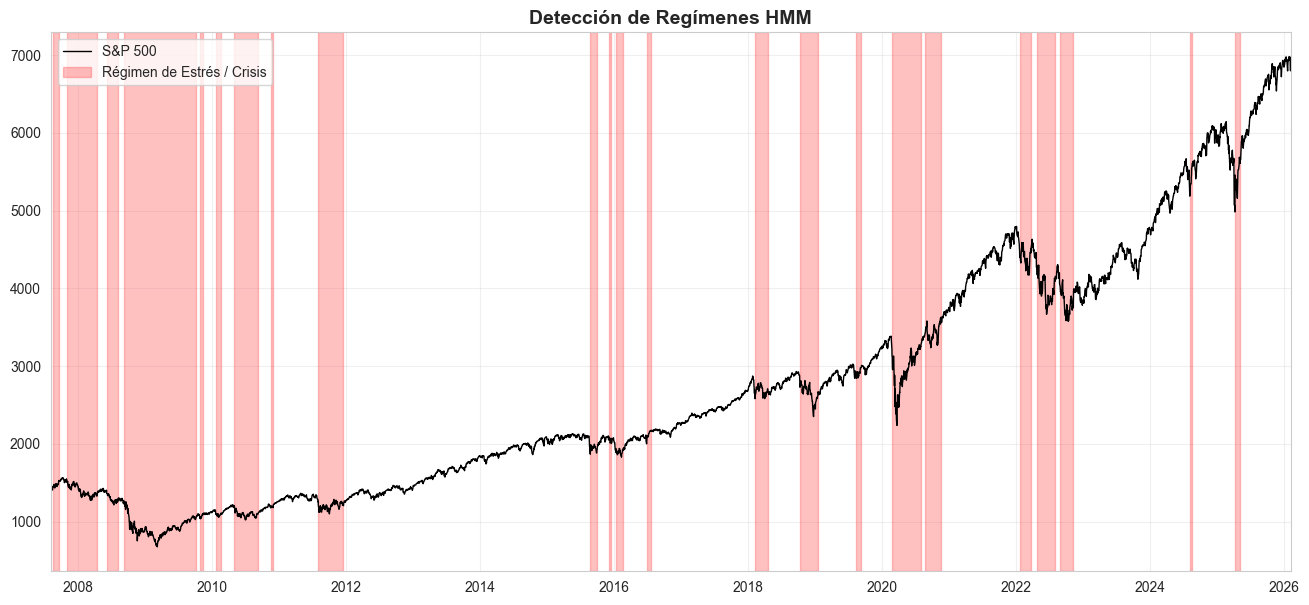


ANÁLISIS DE RESULTADOS

--- MATRIZ DE TRANSICIÓN ESTIMADA ---
            A CALMA  A CRISIS
De CALMA   0.985430  0.014570
De CRISIS  0.033608  0.966392

-> Persistencia de la Crisis: 96.64%

Porcentaje de tiempo en Crisis (2006-Hoy): 26.9%
✅ RESULTADO VÁLIDO: El modelo captura crisis sistémicas y correcciones severas.


In [31]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. PREPARACIÓN DE VARIABLES
# ------------------------------------------------------------------
# Como ya calculamos todo en la Fase 0, solo seleccionamos las columnas.
# Usamos las variables que mejor distinguen Pánico de Euforia.

feature_cols = [
    'S&P500_Ret',      # Movimiento del precio
    'Downside_Vol',    # Miedo Realizado (Filtra subidas)
    'VIX_Level',       # Expectativa de Miedo
    'Credit_Shock'     # Pánico en Bonos (Variación diaria)
]

print(f"Variables seleccionadas para el modelo: {feature_cols}")

# Verificamos que no haya NaNs
df_model = df_hmm_clean[feature_cols].dropna()
X_input = df_model.values

# Estandarización (CRUCIAL para que el VIX no domine a los retornos)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_input)

# 2. DEFINICIÓN DEL MODELO HMM
# ------------------------------------------------------------------
model = GaussianHMM(
    n_components=2, 
    covariance_type="full", 
    n_iter=1000, 
    random_state=42, 
    init_params='stmc'
)

# CALIBRACIÓN 
# Forzamos una matriz para reducir el ruido.
# Es difícil entrar en crisis (1%), pero una vez dentro, es difícil salir (95%).
model.transmat_ = np.array([
    [0.99, 0.01],  # De Calma a Crisis: Solo 1% de probabilidad
    [0.05, 0.95]   # De Crisis a Crisis: 95% de persistencia
])

print("Entrenando modelo (Algoritmo EM)...")
model.fit(X_scaled)
hidden_states = model.predict(X_scaled)

# 3. IDENTIFICACIÓN DEL RÉGIMEN (¿Cuál es el 0 y cuál el 1?)
# ------------------------------------------------------------------
# El estado con mayor Downside Volatility es la Crisis.
vol_0 = df_hmm_clean['Downside_Vol'].iloc[hidden_states == 0].mean()
vol_1 = df_hmm_clean['Downside_Vol'].iloc[hidden_states == 1].mean()

if vol_0 < vol_1:
    crisis_state = 1
    calm_state = 0
else:
    crisis_state = 0
    calm_state = 1

print(f"-> Estado detectado como CRISIS: {crisis_state}")

# 4. FILTRO DE CONSISTENCIA
# ------------------------------------------------------------------
# Una crisis se confirma si persiste durante 1 mes (21 días).
raw_signal = (hidden_states == crisis_state).astype(int)

# Media móvil centrada de 21 días
smoothed_signal = pd.Series(raw_signal, index=df_model.index).rolling(window=21, center=True).mean()

# Umbral de decisión: > 60% de probabilidad en la ventana
final_regime = (smoothed_signal > 0.6).astype(int)

# Guardamos el régimen final en el DataFrame principal
df_hmm_clean['Regime'] = final_regime

# 5. VISUALIZACIÓN 
# ------------------------------------------------------------------
df_hmm_clean.index = pd.to_datetime(df_hmm_clean.index)
prices = market_prices['SP500'].reindex(df_hmm_clean.index)

fig, ax = plt.subplots(figsize=(16, 7))

# Precio S&P 500
ax.plot(prices.index, prices, color='black', linewidth=1, label='S&P 500')

# Sombreado de Crisis
is_crisis = (df_hmm_clean['Regime'] == 1)
ax.fill_between(prices.index, 0, 1, where=is_crisis, 
                color='#ff4d4d', alpha=0.35, transform=ax.get_xaxis_transform(), 
                label='Régimen de Estrés / Crisis')

ax.set_title('Detección de Regímenes HMM', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(prices.index[0], prices.index[-1])

# Formato Fechas
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# ==============================================================================
# ESTADÍSTICAS Y MATRIZ DE TRANSICIÓN
# ==============================================================================
print("\n" + "="*50)
print("ANÁLISIS DE RESULTADOS")
print("="*50)

# 1. Matriz de Transición
labels = {calm_state: 'CALMA', crisis_state: 'CRISIS'}
state_names = [labels[i] for i in range(2)]

trans_df = pd.DataFrame(model.transmat_, 
                        index=[f'De {name}' for name in state_names],
                        columns=[f'A {name}' for name in state_names])

print("\n--- MATRIZ DE TRANSICIÓN ESTIMADA ---")
print(trans_df)

# 2. Persistencia
prob_stay_crisis = model.transmat_[crisis_state, crisis_state]
print(f"\n-> Persistencia de la Crisis: {prob_stay_crisis:.2%}")

# 3. Resumen Histórico
pct_crisis = df_hmm_clean['Regime'].mean()
print(f"\nPorcentaje de tiempo en Crisis (2006-Hoy): {pct_crisis:.1%}")

if 0.15 <= pct_crisis <= 0.30:
    print("✅ RESULTADO VÁLIDO: El modelo captura crisis sistémicas y correcciones severas.")
else:
    print("⚠️ REVISAR: El porcentaje de crisis está fuera del rango típico (15-30%).")
print("="*50)